### Transistor model for AMF technology, namely the designed transistor and the paper transistor.

#### My transistor 
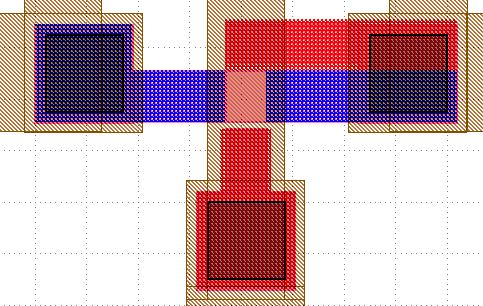

#### Paper transistor 

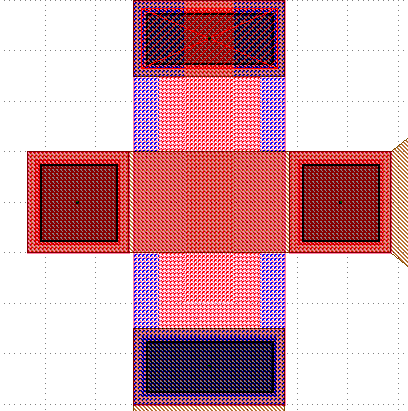





La fréquence de gain unitaire peut être décrite comme ceci : 
$$Ft = \frac{gm}{2\pi (C_{gs}+C_{gd})} $$
Soit le gain petit signal sur les capacités dominantes.
La valeur gm dépends de Vov, comme suit : 
$$ gm = \mu_n C_{ox} \frac{W}{L} (V_{gs}-V_t) $$
où 
$$V_t = V_{fb} + 2*\phi_F + \frac{\sqrt{2\epsilon_s qN_a(2\phi_F)}}{C_{ox}} $$
et
$$ V_{fb} = \phi_m - \phi_s - \frac{Q_{ox}}{C_{ox}} $$

Le flatband voltage est la différence entre les work function de la gate et du canal.

$$ \phi_{}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte

$$ V_{T0} = \frac{\sqrt{2\epsilon_{Si}*q*N_A(2\phi_F)}}{C_{ox}}-2\phi_F$$

$$2\phi_F = \frac{2K_BT}{q}ln\frac{N}{n_i} $$ 

$$ C_{ox} = \frac{\epsilon_{ox}}{t_{ox}} $$

In [4]:
def Si_work_fn(doping, doping_type, temperature=300):

    """
    Calculate the work function of silicon with doping and temperature.

    Parameters:
        doping (float): Doping concentration in cm^-3 (e.g., 1e16 for 10^16 cm^-3).
        doping_type (str): Type of doping ('n' for n-type, 'p' for p-type).
        temperature (float): Temperature in Kelvin (default is 300 K).

    Returns:
        float: Work function of silicon in eV.
    """
    # Constants
    k_B_eV = cte.k / cte.electron_volt  # Boltzmann constant in eV/K
    electron_affinity = 4.05  # Electron affinity of silicon in eV
    band_gap = 1.12  # Bandgap of silicon in eV
    intrinsic_carrier_concentration = 1.5e10  # Intrinsic carrier concentration in cm^-3 at 300 K
    
    # Calculate Fermi level shift
    if doping_type.lower() == 'n':
        fermi_shift = k_B_eV * temperature * np.log(doping / intrinsic_carrier_concentration)
        work_function = electron_affinity + (band_gap / 2) - fermi_shift
    elif doping_type.lower() == 'p':
        fermi_shift = k_B_eV * temperature * np.log(doping / intrinsic_carrier_concentration)
        work_function = electron_affinity + (band_gap / 2) + fermi_shift
    else:
        raise ValueError("Invalid doping_type. Use 'n' for n-type or 'p' for p-type.")
    
    return work_function

def C_ox(t_ox_nm, k_ox=3.9):
    """
    Calculate the oxide capacitance per unit area (C_ox) for a MOS capacitor.

    Parameters:
        t_ox_nm (float): Thickness of the oxide layer in nanometers (nm).
        k_ox (float): Relative permittivity (dielectric constant) of the oxide material.
                      Default is 3.9 (for silicon dioxide, SiO2).

    Returns:
        float: Oxide capacitance per unit area (C_ox) in F/cm^2.
    """
    # Convert t_ox from nm to meters
    t_ox_m = t_ox_nm * 1e-7  # nm to cm
    
    # Permittivity of the oxide layer
    epsilon_ox = cte.epsilon_0 * k_ox *1e2  # F/cm
    
    # Capacitance per unit area
    cox = epsilon_ox / t_ox_m  # F/cm^2
    
    return cox

def doping_fn(regions, total_depth):
    """
    Calculate the resultant doping density with overlapping implants.

    Parameters:
    regions (list of tuples): Each tuple contains (doping_density, thickness) in cm^-3 and nm.
    total_depth (float): Total gate depth in nm.

    Returns:
    float: Resultant doping density in cm^-3.
    """
    total_doping = sum(density * thickness for density, thickness in regions)
    return total_doping / total_depth

def TwoPhi_F_fn(doping, doping_type, temperature=300, n_i=1.5e10):
    """
    Calculate 2ΦF (twice the Fermi potential) for a semiconductor.
    
    Parameters:
        doping (float): Doping concentration in cm^-3 (e.g., 1e16 for 10^16 cm^-3).
        doping_type (str): Type of doping ('n' for n-type, 'p' for p-type).
        temperature (float): Temperature in Kelvin (default is 300 K).
        n_i (float): Intrinsic carrier concentration in cm^-3 (default is 1.5e10 for silicon at 300 K).
    
    Returns:
        float: Value of 2ΦF in eV.
    """
    # Convert Boltzmann constant to eV/K
    k_B_eV = cte.k / cte.electron_volt  # in eV/K
    
    # Ensure doping_type is valid
    if doping_type.lower() not in ('n', 'p'):
        raise ValueError("Invalid doping_type. Use 'n' for n-type or 'p' for p-type.")
    
    # Calculate 2ΦF
    if doping_type.lower() == 'n':
        PhiF = k_B_eV * temperature * np.log(doping / n_i)  # n-type
    else:
        PhiF = k_B_eV * temperature * np.log(n_i / doping)  # p-type
    
    return 2 * PhiF

def calculate_vt(Vfb, two_phi_F, Cox, doping, doping_type, temperature=300):
    """
    Calculate the threshold voltage (Vt) of a MOSFET.

    Parameters:
        Vfb (float): Flat-band voltage (in volts).
        two_phi_F (float): Twice the Fermi potential (in volts).
        Cox (float): Oxide capacitance per unit area (in F/cm^2).
        doping (float): Doping concentration in cm^-3.
        doping_type (str): Type of doping ('n' for n-type, 'p' for p-type).
        temperature (float): Temperature in Kelvin (default is 300 K).
    
    Returns:
        float: Threshold voltage (Vt) in volts.
    """
    # Constants
    k_s = 11.7  # Relative permittivity of silicon
    epsilon_s = cte.epsilon_0 * k_s  # Absolute permittivity of silicon (F/m)
    
    # Convert Cox from F/cm^2 to F/m^2
    Cox_m2 = Cox * 1e4  # 1 cm^2 = 1e-4 m^2
    
    # Depletion region term
    depletion_term = np.sqrt(2 * cte.e * epsilon_s * doping * abs(two_phi_F)) / Cox_m2
    
    # Calculate Vt
    Vt = Vfb + two_phi_F + depletion_term
    return Vt

#Pour un NMOS, Grille P, channel P
# 
# Inputs
regions = [
    (1.011e20, 90),  # Region 1: Combined CONT, Medium, and Standard (0–90 nm) 
    (1e17, 130)       # Region 3: Standard only (130–220 nm)
]
total_depth = 220  # Total gate depth in nm
V_fb = Si_work_fn(doping=doping_fn(regions,total_depth),doping_type='p')- Si_work_fn(doping=1e15,doping_type='p')
TwoPhi = TwoPhi_F_fn(doping=1e15, doping_type = 'p', temperature=300, n_i=1.5e10)
Cox = C_ox(140)
print(TwoPhi)

Vt = calculate_vt(V_fb,TwoPhi,Cox,doping=1e15,doping_type='p' )

print(Vt)
""" 
f1 = plt.figure()
plt.plot(t_ox, Vt, 'r-', label='N')
plt.grid()
plt.legend(loc='best')
plt.xlabel('t_ox')
plt.ylabel('Vt')  
 """
###


-0.5743001255468786
-0.29945517399234556


" \nf1 = plt.figure()\nplt.plot(t_ox, Vt, 'r-', label='N')\nplt.grid()\nplt.legend(loc='best')\nplt.xlabel('t_ox')\nplt.ylabel('Vt')  \n "

In [5]:
import numpy as np
from scipy.constants import k as k_B, e as q, epsilon_0

def calculate_threshold_voltage(t_ox_nm, doping_channel, type_channel, doping_profile, temperature=300, Eg=1.12, ni_300K=1.5e10):
    """
    Improved function to calculate the threshold voltage (Vt) of a transistor with a gate doping profile.
    The model now includes more precise calculations for high doping and band-gap narrowing.

    Parameters:
    t_ox_nm (float or np.array): Oxide thickness in nanometers.
    doping_channel (float): Channel doping concentration (N_A or N_D) in cm^-3.
    type_channel (str): Channel doping type ('p' for p-type or 'n' for n-type).
    doping_profile (list of lists): Gate doping profile as [[doping, depth], ...].
    temperature (float): Temperature in Kelvin (default is 300 K).
    Eg (float): Bandgap of silicon at 300 K in eV (default is 1.12 eV).
    ni_300K (float): Intrinsic carrier concentration at 300 K in cm^-3 (default is 1.5e10 cm^-3).

    Returns:
    float: Threshold voltage (Vt) in volts.
    """
    # Constants
    epsilon_ox = 3.9 * epsilon_0 *1e-2 # Permittivity of silicon dioxide in F/cm
    epsilon_si = 11.7 * epsilon_0 *1e-2 # Permittivity of silicon in F/m
    Vt_thermal = (k_B * temperature) / q  # Thermal voltage (in volts)

    # Oxide capacitance per unit area (Cox)
    t_ox_cm = t_ox_nm * 1e-7  # Convert nm to cm
    Cox = epsilon_ox / t_ox_cm  # F/cm^2

    # Calculate the 2 * phi_F for the channel
    def calculate_2_phi_F(doping_channel, type_channel):
        phi_F = Vt_thermal * np.log(doping_channel / ni_300K)
        if type_channel == 'n':
            phi_F = -phi_F  # Reverse sign for n-type channel
        return 2 * phi_F

    two_phi_F_channel = calculate_2_phi_F(doping_channel, type_channel)

    # Calculate the effective work function of the gate (phi_m) considering BGN
    total_doping_depth = sum([segment[1] for segment in doping_profile])
    phi_F_gate_sum = 0
    phi_m = phi_F_gate_sum + (Eg / 2 if type_channel == 'p' else -Eg / 2)

    # Channel work function (phi_s) calculation
    if type_channel == 'p':
        phi_s = (Eg / 2) + two_phi_F_channel
    else:
        phi_s = (-Eg / 2) + two_phi_F_channel

    # Flatband voltage (Vfb)
    Vfb = phi_m - phi_s

    # Threshold voltage (Vt) calculation with consideration for high doping
    Vt = Vfb + two_phi_F_channel + np.sqrt(2 * q * epsilon_si * np.abs(doping_channel) * np.abs(two_phi_F_channel)) / Cox

    return Vt

# Parameters
t_ox_nm = np.array([140,200])  # Oxide thickness in nm
doping_channel = 5.5e15  # Channel doping concentration in cm^-3
type_channel = 'p'  # Channel type
doping_profile = [[1e17, 220]]  # Gate doping profile
temperature = 300  # Temperature in K

# Compute Vt for the given parameters
Vt_result = calculate_threshold_voltage(t_ox_nm, doping_channel, type_channel, doping_profile, temperature)
print(f"Threshold Voltage (Vt): {Vt_result} V")


Threshold Voltage (Vt): [1.40996263 2.01423233] V


Text(0.5, 1.0, 'Changes in Vt in function of the channel doping for NMOS transistor')

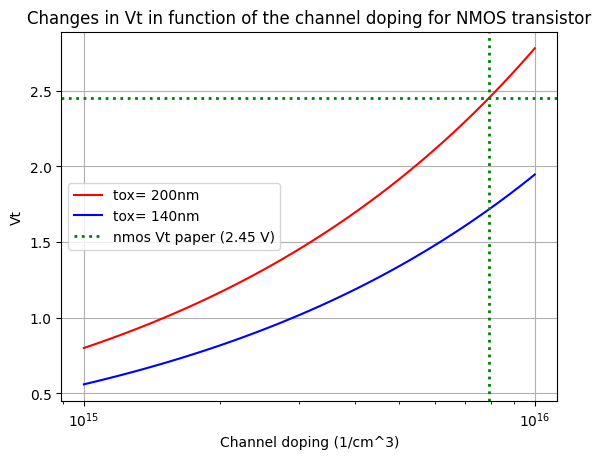

In [6]:
# Parameters
t_ox_nm = 200  # Oxide thickness in nm
doping_channel = np.logspace(15,16,100)  # Channel doping concentration in cm^-3
#print(doping_channel)
type_channel = 'p'  # Channel type
doping_profile = [[1e20,90],[1e17, 130]]  # Gate doping profile
temperature = 300  # Temperature in K

# Compute Vt for the given parameters
Vt_result_200 = calculate_threshold_voltage(t_ox_nm, doping_channel, type_channel, doping_profile, temperature)
closest_index = None
closest_diff = float('inf')  # Start with an infinitely large difference
# Using a for loop to find the closest index
for i, value in enumerate(Vt_result_200):
    diff = abs(value - 2.45)  # Calculate the absolute difference
    if diff < closest_diff:  # If the difference is smaller, update
        closest_diff = diff
        closest_index = i

t_ox_nm = 140  # Oxide thickness in nm
Vt_result_140 = calculate_threshold_voltage(t_ox_nm, doping_channel, type_channel, doping_profile, temperature)

f1 = plt.figure()
plt.plot(doping_channel, Vt_result_200, 'r-', label='tox= 200nm')
plt.plot(doping_channel, Vt_result_140, 'b-', label='tox= 140nm')
plt.grid()
plt.xlabel('Channel doping (1/cm^3)')
plt.ylabel('Vt')  
plt.xscale('log')
plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
plt.axhline(y=2.45, color='g', linestyle=':', linewidth=2, label = 'nmos Vt paper (2.45 V)')
plt.legend(loc='best')
plt.title('Changes in Vt in function of the channel doping for NMOS transistor')



Text(0.5, 1.0, 'Changes in Vt in function of the channel doping for PMOS transistor')

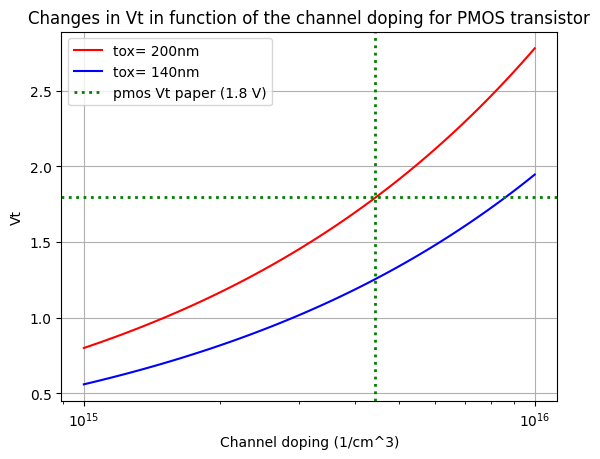

In [7]:
# Parameters
t_ox_nm = 200  # Oxide thickness in nm
doping_channel = np.logspace(15,16,100)  # Channel doping concentration in cm^-3
#print(doping_channel)
type_channel = 'n'  # Channel type
doping_profile = [[1e20,90],[1e17, 130]]  # Gate doping profile
temperature = 300  # Temperature in K

# Compute Vt for the given parameters
Vt_result_200 = calculate_threshold_voltage(t_ox_nm, doping_channel, type_channel, doping_profile, temperature)
closest_index = None
closest_diff = float('inf')  # Start with an infinitely large difference
# Using a for loop to find the closest index
for i, value in enumerate(Vt_result_200):
    diff = abs(value - 1.8)  # Calculate the absolute difference
    if diff < closest_diff:  # If the difference is smaller, update
        closest_diff = diff
        closest_index = i

t_ox_nm = 140  # Oxide thickness in nm
Vt_result_140 = calculate_threshold_voltage(t_ox_nm, doping_channel, type_channel, doping_profile, temperature)

f1 = plt.figure()
plt.plot(doping_channel, Vt_result_200, 'r-', label='tox= 200nm')
plt.plot(doping_channel, Vt_result_140, 'b-', label='tox= 140nm')
plt.grid()
plt.xlabel('Channel doping (1/cm^3)')
plt.ylabel('Vt')  
plt.xscale('log')
plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
plt.axhline(y=1.8, color='g', linestyle=':', linewidth=2, label = 'pmos Vt paper (1.8 V)')
plt.legend(loc='best')
plt.title('Changes in Vt in function of the channel doping for PMOS transistor')



<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Philippe Arsenault\AppData\Local\Temp\ipykernel_33376\1102135537.py:9: SyntaxWarning: invalid escape sequence '\m'
  """


Text(0.5, 1.0, 'Changes in the gain factor in function of the channel doping for NMOS transistor')

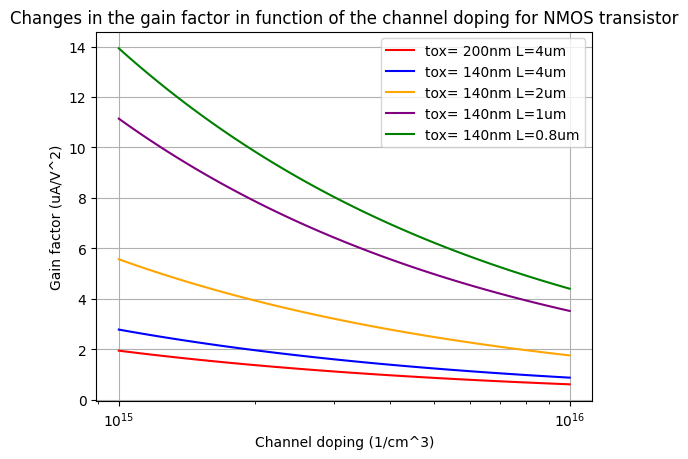

In [8]:
import numpy as np
from scipy.constants import epsilon_0, micro  # epsilon_0 for permittivity of free space, micro for conversion to micrometers

# Constants
epsilon_sio2 = 3.45e-13  # Permittivity of SiO2 in F/cm
W = 220e-7  # Width in cm (220 nm)

def calculate_gain_factor(t_ox_nm, doping_channel, channel_type='n', L_um=1, W = 220e-7):
    """
    Calculate the gain factor \mu C_ox * (W/L) for a transistor.
    
    Parameters:
    - t_ox_nm: Oxide thickness in nm.
    - doping_channel: Doping concentration of the channel in cm^-3.
    - channel_type: 'n' for NMOS (n-type), 'p' for PMOS (p-type).
    - L_um: Channel length in micrometers (default is 1 um).
    
    Returns:
    - Gain factor: \mu C_ox * (W/L).
    """
    
    # Convert L_um from micrometers to centimeters
    L = L_um * 1e-4  # Convert micrometers to cm
    
    # Convert oxide thickness to cm
    t_ox = t_ox_nm * 1e-7  # Convert nm to cm
    
    # Calculate C_ox (oxide capacitance)
    C_ox = epsilon_sio2 / t_ox  # F/cm^2
    
    # Doping dependent mobility models (using typical values for Si)
    N_ref = 1e16  # Reference doping concentration in cm^-3
    
    # For NMOS (n-type channel)
    if channel_type == 'n':
        mu_n0 = 650  # Mobility at low doping concentration (cm^2/V·s)
        mu_n = mu_n0 * (doping_channel / N_ref)**-0.5  # Doping dependence model
    # For PMOS (p-type channel)
    elif channel_type == 'p':
        mu_p0 = 250  # Mobility at low doping concentration (cm^2/V·s)
        mu_p = mu_p0 * (doping_channel / N_ref)**-0.5  # Doping dependence model
    else:
        raise ValueError("Invalid channel type. Use 'n' for NMOS or 'p' for PMOS.")
    
    # Gain factor calculation: \mu C_ox * (W/L)
    gain_factor = mu_n * C_ox * (W / L) if channel_type == 'n' else mu_p * C_ox * (W / L)
    
    return gain_factor

# Example usage
t_ox_nm = 200  # Oxide thickness in nm
doping_channel = np.logspace(15,16,100)  # Doping concentration in cm^-3 
channel_type = 'n'  # 'n' for NMOS, 'p' for PMOS
L_um = 4  # Length in micrometers 

gain_200 = calculate_gain_factor(t_ox_nm, doping_channel, channel_type, L_um)
t_ox_nm = 140  # Oxide thickness in nm
gain_140 = calculate_gain_factor(t_ox_nm, doping_channel, channel_type, L_um)
L_um = 2  # Length in micrometers 
gain_140_20 = calculate_gain_factor(t_ox_nm, doping_channel, channel_type, L_um)
L_um = 1  # Length in micrometers 
gain_140_10 = calculate_gain_factor(t_ox_nm, doping_channel, channel_type, L_um)
L_um = 0.8  # Length in micrometers 
gain_140_08 = calculate_gain_factor(t_ox_nm, doping_channel, channel_type, L_um)
f1 = plt.figure()
plt.plot(doping_channel, gain_200/1e-6, 'r-', label='tox= 200nm L=4um')
plt.plot(doping_channel, gain_140/1e-6, 'b-', label='tox= 140nm L=4um')
plt.plot(doping_channel, gain_140_20/1e-6,color='orange',linestyle =  '-', label='tox= 140nm L=2um')
plt.plot(doping_channel, gain_140_10/1e-6, color='purple',linestyle =  '-', label='tox= 140nm L=1um')
plt.plot(doping_channel, gain_140_08/1e-6, color='Green',linestyle =  '-', label='tox= 140nm L=0.8um')
plt.grid()
plt.xlabel('Channel doping (1/cm^3)')
plt.ylabel('Gain factor (uA/V^2)')  
plt.xscale('log')
#plt.yscale('log')
#plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
#plt.axhline(y=1.8, color='g', linestyle=':', linewidth=2, label = 'pmos Vt paper (1.8 V)')
plt.legend(loc='best')
plt.title('Changes in the gain factor in function of the channel doping for NMOS transistor')


Les valeurs standards semble se rapprocher de 5e15 doping. C'est donc ce qui va être utiliser pour le reste des calculs.

Le early Voltage est difficile à calculer analytiquement. Je vais donc prendre les valeurs de l'article soit 35V pour un NMOS et 55V pour un PMOS

Text(0.5, 1.0, 'ID vs VDS')

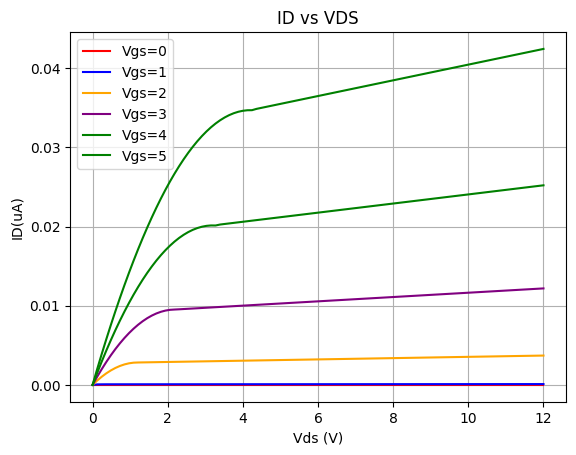

In [9]:
import numpy as np
from scipy.constants import epsilon_0, e

import numpy as np

def mosfet_id(mosfet_type, W_L, Vt, Vgs, Vds, channel_doping, doping_type, Cox):
    """
    Calculate the drain current (ID) of a MOSFET using triode and saturation models.

    Parameters:
        mosfet_type (str): Type of MOSFET ('NMOS' or 'PMOS').
        W_L (float): Width-to-length ratio of the MOSFET.
        Vt (float): Threshold voltage (in volts).
        Vgs (float or np.ndarray): Gate-to-source voltage (in volts).
        Vds (float or np.ndarray): Drain-to-source voltage (in volts).
        channel_doping (float): Channel doping concentration (in cm^-3).
        doping_type (str): Type of doping ('n' for n-type, 'p' for p-type).
        Cox (float): Gate oxide capacitance per unit area (in F/cm^2).

    Returns:
        np.ndarray: The drain current ID (in amperes).
    """
    # Calculate mobility based on channel doping and type
    mobility = calculate_mobility(channel_doping, doping_type)

    # Ensure Vgs and Vds are numpy arrays
    Vgs = np.array(Vgs, dtype=float)
    Vds = np.array(Vds, dtype=float)

    # Constants for Early voltage (VA)
    VA_NMOS = 35  # Early voltage for NMOS (in volts)
    VA_PMOS = 55  # Early voltage for PMOS (in volts)

    # Check the MOSFET type and assign appropriate Early voltage and polarity adjustments
    if mosfet_type.upper() == 'NMOS':
        VA = VA_NMOS
        polarity = 1
    elif mosfet_type.upper() == 'PMOS':
        VA = VA_PMOS
        polarity = -1
    else:
        raise ValueError("Invalid MOSFET type. Use 'NMOS' or 'PMOS'.")

    # Correct voltages for PMOS if necessary
    Vgs *= polarity
    Vds *= polarity

    # Calculate the transconductance parameter (k')
    k_prime = mobility * Cox  # In A/V^2

    # Initialize the output current array
    ID = np.zeros((len(Vgs), len(Vds)))

    # Loop through Vgs and Vds to calculate ID
    for i, vg in enumerate(Vgs):
        for j, vd in enumerate(Vds):
            if vg <= Vt:
                # Cutoff region: ID = 0
                ID[i, j] = 0.0
            elif vd < (vg - Vt)+0.1:
                # Triode region
                ID[i, j] = k_prime * W_L * ((vg - Vt) * vd - 0.5 * vd**2)
            else:
                # Saturation region
                ID[i, j] = 0.5 * k_prime * W_L * (vg - Vt)**2 * (1 + (vd-(vg-Vt)) / VA)

    return polarity * ID

def calculate_mobility(channel_doping, doping_type):
    """
    Calculate the mobility of carriers in silicon based on channel doping and type.

    Parameters:
        channel_doping (float): Channel doping concentration (in cm^-3).
        doping_type (str): Type of doping ('n' for n-type, 'p' for p-type).

    Returns:
        float: Carrier mobility (in cm^2/Vs).
    """
    # Electron and hole mobility models based on empirical data
    if doping_type == 'n':
        # Electron mobility as a function of doping concentration
        mobility = 1350 / (1 + (channel_doping / 1.5e16)**0.68)
    elif doping_type == 'p':
        # Hole mobility as a function of doping concentration
        mobility = 480 / (1 + (channel_doping / 1.5e16)**0.68)
    else:
        raise ValueError("Invalid doping type. Use 'n' or 'p'.")

    return mobility


# Example inputs
mosfet_type = "NMOS"
w = 0.22
l = 4
W_L = w/l  # Width-to-length ratio
Vt = calculate_threshold_voltage(200,1e15,'p',doping_profile)  # Threshold voltage in volts
Vgs = np.array([0, 1, 2, 3, 4, 5])  # Gate-to-source voltage in volts
Vds = np.linspace(0, 12, 100)  # Drain-to-source voltage from 0 to 5 volts
Cox = C_ox(200)  # Gate oxide capacitance per unit area in F/cm^2

ID = mosfet_id(mosfet_type, W_L, Vt, Vgs, Vds, 1e15, 'p', Cox)

f1 = plt.figure()
plt.plot(Vds, ID[0,:], 'r-', label='Vgs=0')
plt.plot(Vds, ID[1,:], 'b-', label='Vgs=1')
plt.plot(Vds, ID[2,:],color='orange',linestyle =  '-', label='Vgs=2')
plt.plot(Vds, ID[3,:], color='purple',linestyle =  '-', label='Vgs=3')
plt.plot(Vds, ID[4,:], color='Green',linestyle =  '-', label='Vgs=4')
plt.plot(Vds, ID[5,:], color='Green',linestyle =  '-', label='Vgs=5')
plt.grid()
plt.xlabel('Vds (V)')
plt.ylabel('ID(uA)')  
#plt.xscale('log')
#plt.yscale('log')
#plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
#plt.axhline(y=1.8, color='g', linestyle=':', linewidth=2, label = 'pmos Vt paper (1.8 V)')
plt.legend(loc='best')
plt.title('ID vs VDS')



Réponse fréquentielle.

$$ gm = uCoxW/L(Vgs-Vt)$$

$$Ft = \frac{gm}{2\pi (C_{gs}+C_{gd})}$$

$$C_{gs} = \frac{2}{3}WLC_{ox}+WL_{ov}C_{ox}$$

Dans notre cas, estimons Lov à 100nm.
$$ C_{gd} = WL_{ov}C_{ox} $$ 

On peut réduire l'expression à : 

$$ Ft = \frac{u(V_{gs}-V_t)}{2\pi(2/3*L^2+2L_{ov}*L)}$$



Text(0.5, 1.0, 'Transistor maximum frequency')

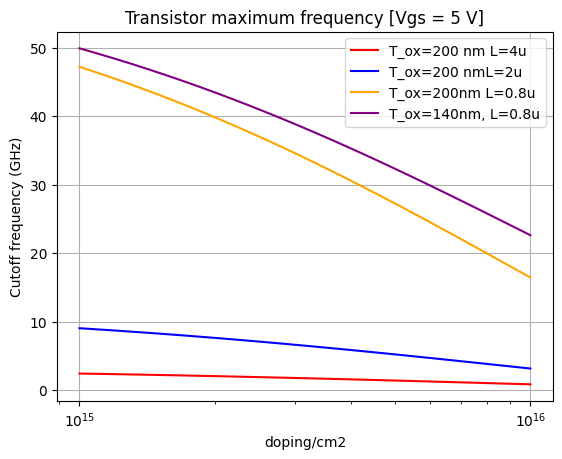

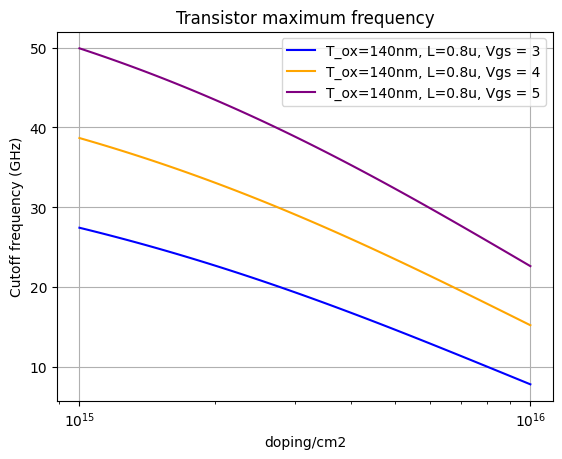

In [10]:
t_ox = 200
L = 4*1e-4 # um en cm)
Lov = 0.1*1e-4 # um en cm)
Vgs = 5



Vt = calculate_threshold_voltage(t_ox,doping_channel,'p',doping_profile)
u = calculate_mobility(doping_channel,'p')
Ft4 = u*(Vgs-Vt)/(2*cte.pi*(2/3*L**2+2*Lov*L))

L = 2*1e-4

Vt = calculate_threshold_voltage(t_ox,doping_channel,'p',doping_profile)
u = calculate_mobility(doping_channel,'p')
Ft2 = u*(Vgs-Vt)/(2*cte.pi*(2/3*L**2+2*Lov*L))

L = 0.8*1e-4

Vt = calculate_threshold_voltage(t_ox,doping_channel,'p',doping_profile)
Ft08 = u*(Vgs-Vt)/(2*cte.pi*(2/3*L**2+2*Lov*L))

t_ox = 140

Vt = calculate_threshold_voltage(t_ox,doping_channel,'p',doping_profile)
Ft0814 = u*(Vgs-Vt)/(2*cte.pi*(2/3*L**2+2*Lov*L))



f1 = plt.figure()
plt.plot(doping_channel, Ft4/1e9, 'r-', label='T_ox=200 nm L=4u')
plt.plot(doping_channel, Ft2/1e9, 'b-', label='T_ox=200 nmL=2u')
plt.plot(doping_channel, Ft08/1e9,color='orange',linestyle =  '-', label='T_ox=200nm L=0.8u')
plt.plot(doping_channel, Ft0814/1e9, color='purple',linestyle =  '-', label='T_ox=140nm, L=0.8u')

plt.grid()
plt.xlabel('doping/cm2')
plt.ylabel('Cutoff frequency (GHz)')  
plt.xscale('log')
#plt.yscale('log')
#plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
#plt.axhline(y=1.8, color='g', linestyle=':', linewidth=2, label = 'pmos Vt paper (1.8 V)')
plt.legend(loc='best')
plt.title('Transistor maximum frequency [Vgs = 5 V]')


Vgs=4
Ftv4 = u*(Vgs-Vt)/(2*cte.pi*(2/3*L**2+2*Lov*L))

Vgs = 3

Ftv3 = u*(Vgs-Vt)/(2*cte.pi*(2/3*L**2+2*Lov*L))

f1 = plt.figure()
plt.plot(doping_channel, Ftv3/1e9, 'b-', label='T_ox=140nm, L=0.8u, Vgs = 3')
plt.plot(doping_channel, Ftv4/1e9,color='orange',linestyle =  '-', label='T_ox=140nm, L=0.8u, Vgs = 4')
plt.plot(doping_channel, Ft0814/1e9, color='purple',linestyle =  '-', label='T_ox=140nm, L=0.8u, Vgs = 5')

plt.grid()
plt.xlabel('doping/cm2')
plt.ylabel('Cutoff frequency (GHz)')  
plt.xscale('log')
#plt.yscale('log')
#plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
#plt.axhline(y=1.8, color='g', linestyle=':', linewidth=2, label = 'pmos Vt paper (1.8 V)')
plt.legend(loc='best')
plt.title('Transistor maximum frequency')

Text(0.5, 1.0, 'Annealing spread')

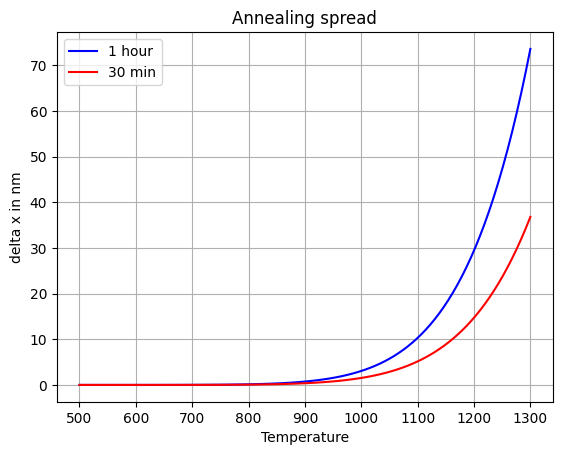

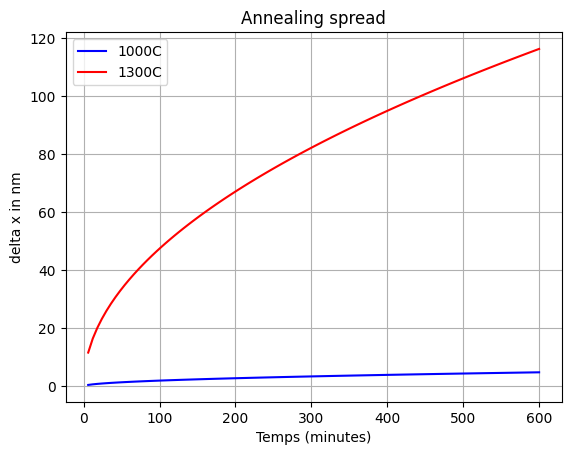

In [27]:
import numpy as np
# Constants
D0 = 1e-3  # Pre-exponential factor for phosphorus in silicon (cm^2/s)
Ea = 3.66  # Activation energy (eV)
kB = 8.617e-5  # Boltzmann constant (eV/K)
T_C =  np.linspace(500,1300,100) # Temperature in Celsius
T_K = T_C + 273.15  # Convert to Kelvin
t = 4 * 3600  # Time in seconds (1 hour)

# Calculate diffusion coefficient (D)
D = D0 * np.exp(-Ea / (kB * T_K))

# Calculate spread (Δx)
delta_x = np.sqrt(2 * D * t)/1e2  # Spread in m


# Calculate spread (Δx)
t2 = 1*3600
delta_x2 = np.sqrt(2 * D * t2)/1e2  # Spread in m


f1 = plt.figure()
plt.plot(T_C, delta_x/1e-9, 'b-', label='1 hour')
plt.plot(T_C, delta_x2/1e-9, 'r-', label='30 min')

plt.grid()
plt.xlabel('Temperature')
plt.ylabel('delta x in nm')  
#plt.xscale('log')
#plt.yscale('log')
#plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
#plt.axhline(y=1.8, color='g', linestyle=':', linewidth=2, label = 'pmos Vt paper (1.8 V)')
plt.legend(loc='best')
plt.title('Annealing spread')


T_C =  1000 # Temperature in Celsius
T_K = T_C + 273.15  # Convert to Kelvin
t = np.linspace(0.1,10,100) * 3600  # Time in seconds (1 hour)

# Calculate diffusion coefficient (D)
D = D0 * np.exp(-Ea / (kB * T_K))

# Calculate spread (Δx)
delta_x = np.sqrt(2 * D * t)/1e2  # Spread in m



# Calculate spread (Δx)
# Calculate diffusion coefficient (D)
T_K2 = 1300+273.15
D2 = D0 * np.exp(-Ea / (kB * T_K2))
delta_x2 = np.sqrt(2 * D2 * t)/1e2  # Spread in m

f1 = plt.figure()
plt.plot(t/60, delta_x/1e-9, 'b-', label='1000C')
plt.plot(t/60, delta_x2/1e-9, 'r-', label='1300C')

plt.grid()
plt.xlabel('Temps (minutes)')
plt.ylabel('delta x in nm')  
#plt.xscale('log')
#plt.yscale('log')
#plt.axvline(x=doping_channel[closest_index], ymin=0, ymax=10, color='g', linestyle=':', linewidth=2)
#plt.axhline(y=1.8, color='g', linestyle=':', linewidth=2, label = 'pmos Vt paper (1.8 V)')
plt.legend(loc='best')
plt.title('Annealing spread')

